# Autoencoder fashion_mnist

### libraries

In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


### load data

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

### reshape and normalize

In [3]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1,image_size,image_size,1])
x_test = np.reshape(x_test,[-1,image_size,image_size,1])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### network parameters

In [12]:
input_shape = (image_size,image_size,1)
batch_size = 32
kernel_size = 3
latent_dim = 16

### encoder / decoder number of filters by CNN layers

In [17]:
layer_filters = [32,64]

### build the autoencoder model

In [18]:
# encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters, kernel_size=kernel_size,
               activation='relu', strides=2,
               padding='same')(x)
    
shape = K.int_shape(x)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


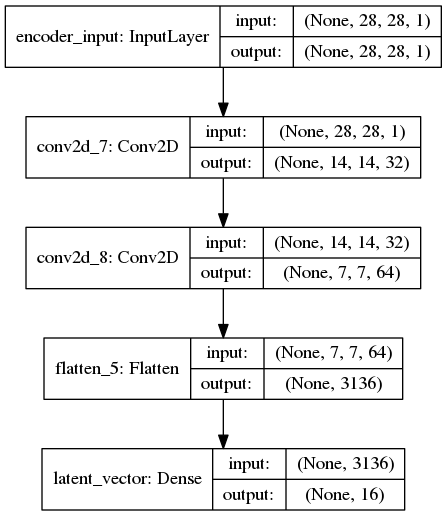

In [19]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

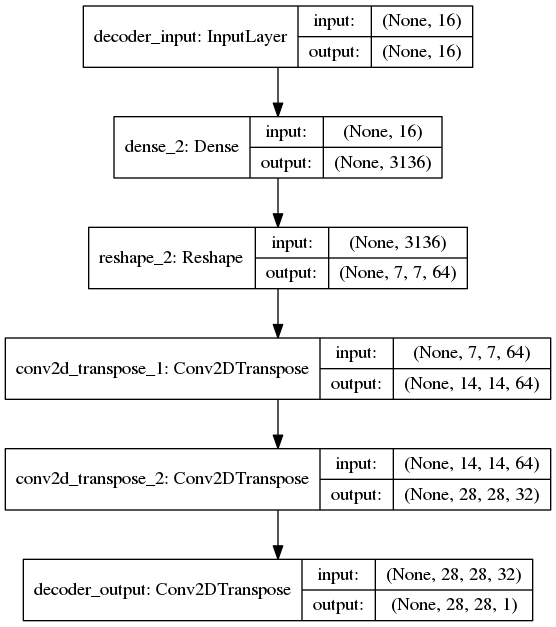

In [20]:
# build the decoder
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                        activation='relu', strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size,
                          activation='sigmoid', padding='same',
                          name='decoder_output')(x)
                          
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

### instantiate autoencoder model

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


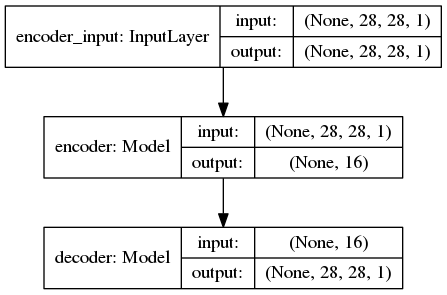

In [21]:
autoencoder = Model(inputs, decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png',
           show_shapes=True)

### MSE loss function, Adam optimizer

In [22]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### train the autoencoder

In [23]:
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test),
                epochs=1, batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 38s 629us/step - loss: 0.0195 - accuracy: 0.5051 - val_loss: 0.0124 - val_accuracy: 0.5057


### predict the autoencoder output from test data

In [24]:
x_decoded = autoencoder.predict(x_test)

### display the 1st 8 test input and decoded images

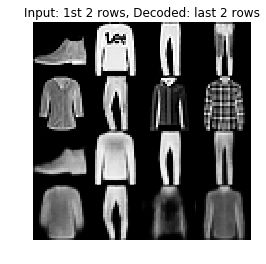

In [25]:
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4,4,image_size,image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()